# Architecture sweep

In [1]:
import sys
sys.path.insert(0, '..')

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from comms import *

# fix random seed
np.random.seed(0)

## Sequential FCN

Using a sequential model so we don't have to write N individual classes for all the configurations we want to explore.

In [2]:
class preamble_detector(nn.Module):
    def __init__(self, num_layers, num_filters, width):
        super(preamble_detector, self).__init__()
        
        pad = int((width-1)/2)
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad)))
        self.conv.add_module(f"relu0", torch.nn.ReLU())
        
        for i in range(num_layers-2):
            self.conv.add_module(f"conv{i+1}", nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad)))
            self.conv.add_module(f"relu{i+1}", torch.nn.ReLU())
        
        self.conv.add_module(f"conv_last", nn.Conv2d(num_filters, 1, 1, 1))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

## Dataset generation

In [3]:
def gen_training_data(preamble_seq, num_examples = 1024, signal_length = 200, payload=128,
                      snr = 10, normalize=False, add_phase_offset=False, add_channel=False, 
                      sample_rate=1e6, add_carrier_offset=False, max_carrier_offset=10e3):

    # Pre-define array to contain complex-valued waveforms
    waveforms = np.zeros((num_examples,signal_length),dtype=np.complex128)

    # Predefine labels array
    labels = np.zeros((num_examples,),dtype=int)
    
    # Generate random payload bits
    bits = np.random.randint(0,2,(num_examples,payload))

    # Add preambles to payloads
    if preamble_seq is not None:
        packets = np.concatenate((np.tile(preamble_seq,(num_examples,1)), bits), axis=1)
    else:
        packets = bits
        preamble_seq = []

    # Map to BPSK symbols
    packets = np.where(packets < 1, -1+0j, 1+0j)

    # Insert into random offset and save offset as label
    for idx, waveform in enumerate(waveforms):
        
        # Get random time offset
        tau = np.random.randint(0,signal_length-payload-len(preamble_seq))
        
        # Insert packet at offset tau
        waveform[tau:tau+payload+len(preamble_seq)] = packets[idx]
        
        # Our label is the same time offset
        labels[idx] = tau
        
        # Add random phase offset
        if add_phase_offset:
            waveforms[idx] = phase_offset(waveform,offset=np.random.randint(-180,high=181))
        else:
            waveforms[idx] = waveform
            
        # Add frequency offset
        if add_carrier_offset:
            carrier_offset = np.random.randint(0, max_carrier_offset)
            offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))
            waveforms[idx] = offset_sine*waveforms[idx]
            
        # Add flat fading channel
        if add_channel:
            gains = 1/np.sqrt(2)*(np.random.randn()+1j*np.random.randn())
            waveforms[idx] = gains*waveforms[idx]
    
    # Add noise
    noisy_waveforms = awgn(waveforms,snr)
    
    # normalize
    if normalize:
        noisy_waveforms = (noisy_waveforms/np.max(np.abs(noisy_waveforms),axis=1)[:,None])

    return noisy_waveforms, labels

# This function takes an array of complex waveforms and associated true offset
# indexes, and returns a 4-D training data tensor compatible with pytorch conv2d layers.
def preprocess(data, labels, to_onehot=True, gpu=True):
    
    # Convert labels to pytorch tensors
    if to_onehot:
        labels_oh = np.zeros(data.shape)
        for idx, label in enumerate(labels):
            labels_oh[idx,label] = 1
        labels = torch.FloatTensor(labels_oh)
    else:
        labels = torch.LongTensor(labels)

    # Split into real and imaginary channels
    train_data = torch.FloatTensor(np.expand_dims(np.stack((data.real, data.imag),axis=1),axis=1))

    # Prep dataset for cuda if gpu true
    if gpu:
        train_data = train_data.cuda()
        labels = labels.cuda()
        
    return train_data, labels

In [ ]:
data_sizes = [1024, 8192]
preamble_lengths = [8, 16, 32]

for data_size in data_sizes:
    for preamble_length in preamble_lengths:
        # training data
        train_data, labels = gen_training_data(signal.max_len_seq(6)[0][:preamble_length], num_examples=data_size, snr=5, add_phase_offset=True, 
                                               add_carrier_offset=True, max_carrier_offset=20e3)
        train_data, labels = preprocess(train_data, labels, to_onehot=True)

        train_dataset = torch.utils.data.TensorDataset(train_data, labels)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

        # validation data
        val_data, val_labels = gen_training_data(signal.max_len_seq(6)[0][:preamble_length], num_examples=256, snr=5, add_phase_offset=True,
                                                 add_carrier_offset=True, max_carrier_offset=20e3)
        val_data, val_labels = preprocess(val_data, val_labels, to_onehot=True)

        val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        dataset = {'train_data': train_data,
                   'labels': labels,
                   'val_data': val_data,
                   'val_labels': val_labels}

        torch.save(dataset, f'data/fcn_data_{preamble_length}_preamble_{data_size}_examples.pt')

In [ ]:
# dataset = torch.load('data/fcn_data_16_preamble_1024_examples.pt')
# # dataset = torch.load('data/fcn_data_8192.pt')

# train_data = dataset['train_data']
# labels = dataset['labels']
# val_data = dataset['val_data']
# val_labels = dataset['val_labels']

# batch_size = 32

# train_dataset = torch.utils.data.TensorDataset(train_data, labels)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [54]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=30, verbose=False):

    train_accs, val_accs = [], []
    losses, val_losses = [], []
    
    best_loss = np.inf

    for epoch in range(num_epochs):
        running_loss = 0
        accuracies = torch.zeros((len(train_loader), train_loader.batch_size)).cuda()
        val_accuracies = torch.zeros((len(val_loader), val_loader.batch_size)).cuda()
        
        for i, (x_train, y_train) in enumerate(train_loader):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x_train)
            loss = loss_fn(outputs, y_train)

            loss.backward()
            optimizer.step()

            running_loss = running_loss + loss.item()
            
            with torch.no_grad():
                accuracies[i] = torch.sum(y_train.argmax(axis=1) == outputs.argmax(axis=1))/train_loader.batch_size

        losses.append(running_loss/len(train_loader))
        
        with torch.no_grad():

            running_val_loss = 0

            for j, (x_val, y_val) in enumerate(val_loader):

                # evaluate validation loss
                val_outputs = model(x_val)
                val_loss = loss_fn(val_outputs, y_val)
                
                running_val_loss = running_val_loss + val_loss.item()
                val_accuracies[j] = torch.sum(y_val.argmax(axis=1) == val_outputs.argmax(axis=1))/val_loader.batch_size

            val_losses.append(running_val_loss/len(val_loader))
            
        if val_losses[-1] < best_loss:
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
            if verbose:
                print(f"Validation loss improved {best_loss}, saving model...")
    
        train_accs.append(torch.mean(accuracies).cpu())
        val_accs.append(torch.mean(val_accuracies).cpu())
    
    model.load_state_dict(saved_model)
            
    return model, losses, val_losses, train_accs, val_accs

In [4]:
num_epochs = 50
num_models = 5
lr = 0.001

layers = [3,4,5]
filter_widths = [3,9,15,35]
filters = [16, 32]
preamble_lengths = [8, 16, 32]

In [ ]:
for length in preamble_lengths:
    print(f'-----Preamble length: {length}-----')
    dataset = torch.load(f'data/fcn_data_{length}_preamble_1024_examples.pt')

    train_data = dataset['train_data']
    labels = dataset['labels']
    val_data = dataset['val_data']
    val_labels = dataset['val_labels']

    batch_size = 32

    train_dataset = torch.utils.data.TensorDataset(train_data, labels)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    for num_layers in layers:
        for filter_width in filter_widths:
            for num_filters in filters:
                models = []
                print(f'Training layers:{num_layers}, width:{filter_width}, filters:{num_filters}')
                for i in range(num_models):
                    print(f'Model {i}...')
                    torch.manual_seed(i)
                    detector = preamble_detector(num_layers, num_filters, filter_width)
                    detector.cuda()

                    optimizer = optim.Adam(detector.parameters(), lr=lr)
                    loss_fn = nn.MSELoss()

                    detector, losses, val_losses, accs, val_accs = train_model(detector, optimizer, loss_fn, train_loader, val_loader, num_epochs=num_epochs, verbose=True)

                    model_config = {"weights": detector.state_dict(),
                                    "losses": losses,
                                    "val_losses": val_losses,
                                    "accs": accs,
                                    "val_accs": val_accs,
                                    "num_epochs": num_epochs,
                                    "lr": lr}

                    models.append(model_config)
                torch.save(models, f'models/{length}_preamble_{num_layers}_layers_{num_filters}_width_{filter_width}_filters.pt')

## Evaluate models

In [6]:
# Returns DER for given pytorch detector, make sure trained detector matches the
# preamble you are testing against
def test_detector(detector, preamble_seq, snr_range=None, num_iter=1500, payload=128, signal_length=200, add_channel=False, 
             abs_phase=False, tau=None, plot=True, add_phase_offset=True, normalize=True, carrier_offset=None):
    
    if snr_range is None:
        snr_range = np.arange(-10,15)

    nn_ers = np.zeros(len(snr_range),)
    
    if carrier_offset:
        offset_sine = np.exp(1j*2*np.pi*(carrier_offset/1e6)*np.arange(signal_length))
    
    for idx, snr in enumerate(snr_range):
        nn_err = float(0)
        for i in range(num_iter):
            
            # Create new frame
            ph = np.random.randint(-180,high=181)
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))

            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
    
            if add_phase_offset:
                my_frame = phase_offset(my_frame, offset=ph)
                
            if carrier_offset is not None:
                my_frame = my_frame*offset_sine

            if add_channel:
                gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
                my_frame = gains*my_frame
                
            # Add noise
            my_frame = awgn(my_frame, snr)
            
            # normalize
            if normalize:
                my_frame = my_frame/np.max(np.abs(my_frame))

            # FCN prediction
            new_frame = np.expand_dims(np.vstack((my_frame.real, my_frame.imag)),axis=(0,1))
            new_frame = torch.tensor(new_frame).float()
            nn_output = detector(new_frame)

            y_nn = torch.argmax(nn_output)

            # Calculate if error
            nn_err = nn_err + (y_nn != tau)

        nn_ers[idx] = nn_err

    nn_ders = nn_ers/num_iter
        
    return nn_ders

In [8]:
cfo = None
runs = 500
snr_range = np.arange(-10,11)

print('Evaling ders vs snrs...')
for length in preamble_lengths:
    print(f'-----{length}-----')
    for num_layers in layers:
        for filter_width in filter_widths:
            for num_filters in filters:
                results = []
                for model in torch.load(f'models/{length}_preamble_{num_layers}_layers_{num_filters}_width_{filter_width}_filters.pt'):
                    detector = preamble_detector(num_layers,num_filters,filter_width)
                    detector.load_state_dict(model['weights'])

                    ders = test_detector(detector, signal.max_len_seq(6)[0][:length], num_iter=runs, add_phase_offset=True, 
                                         carrier_offset=cfo, add_channel=False, snr_range=snr_range)

                    result = {"ders": ders,
                              "model": model,
                              "cfo": cfo,
                              "snr_range": snr_range}

                    results.append(result)
                torch.save(results, f'results/ders_vs_snr_{length}_{num_layers}_{filter_width}_{num_filters}_{cfo}.pt')

Evaling ders vs snrs...
-----8-----
-----16-----
-----32-----


In [22]:
# Function returns the DER of a binary sequence preamble_seq by using the standard
# correlation under selected impairments.
def calculate_baseline(preamble_seq, snr_range, num_iter=1500, payload=128,
                       signal_length=200, add_phase_offset=True, carrier_offset=None,
                       sample_rate=1e6, add_channel=False):
    
    
    preamble = np.where(preamble_seq < 1, -1+0j, 1+0j)

    corr_ers = np.zeros(len(snr_range),)
    
    if carrier_offset:
        offset_sine = np.exp(1j*2*np.pi*(carrier_offset/sample_rate)*np.arange(signal_length))

    for idx, snr in enumerate(snr_range):
        corr_err = float(0)
        for i in range(num_iter):

            # Create new frame with a random tau
            tau = np.random.randint(0,signal_length-payload-len(preamble_seq))
            my_frame = create_frame(preamble_seq, payload=payload, signal_length=signal_length, offset=tau)
            
            if add_phase_offset:
                ph = np.random.randint(-180,high=181)
                my_frame = phase_offset(my_frame, offset=ph)
                
            if carrier_offset is not None:
                my_frame = my_frame*offset_sine
                
            if add_channel:
                gains = 1/np.sqrt(2)*(np.random.normal(0)+1j*np.random.normal(0))
                my_frame = gains*my_frame
                
            # Add noise
            my_frame = awgn(my_frame, snr)
            
            # Find peaks using correlation
            correlation = np.abs(np.correlate(my_frame, preamble, mode='valid'))
            y_corr = np.argmax(correlation)

            # Calculate if error
            corr_err = corr_err + (y_corr != tau)

        corr_ers[idx] = corr_err
  
    corr_ders = corr_ers/num_iter
        
    return corr_ders

baselines = {}
for length in preamble_lengths:
    baselines[length] = calculate_baseline(signal.max_len_seq(6)[0][:length], snr_range, num_iter=1500, payload=128, signal_length=200, add_phase_offset=True, carrier_offset=None)

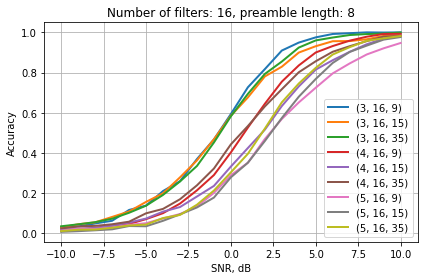

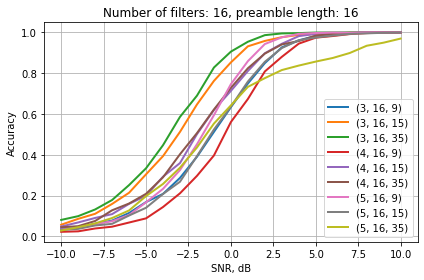

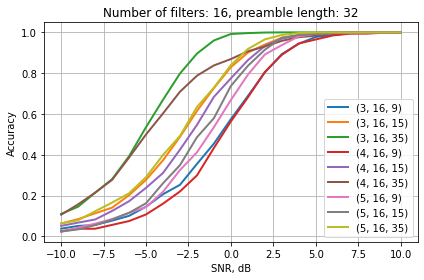

In [35]:
filter_widths = [9, 15, 35]
filters = [16]
cfo=None
legend = [(num_layers, num_filters, filter_width) for num_layers in layers
          for filter_width in filter_widths
          for num_filters in filters]


for length in preamble_lengths:
    plt.figure()
    for num_layers in layers:
        for filter_width in filter_widths:
            for num_filters in filters:
                ders = np.mean([result['ders'] for result in torch.load(f'results/ders_vs_snr_{length}_{num_layers}_{filter_width}_{num_filters}_{cfo}.pt')],axis=0)
                plt.plot(snr_range, 1-ders, linewidth=2)
    # plt.plot(snr_range, 1-baselines[length], 'k--')
    plt.legend(legend, loc='lower right')
    plt.grid()
    plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
    plt.title(f'Number of filters: {num_filters}, preamble length: {length}')
    plt.tight_layout()
    plt.savefig(f'figures/arcv_search_ders_{num_filters}_filters_{length}_width.png', dpi=300, bbox_inches='tight')

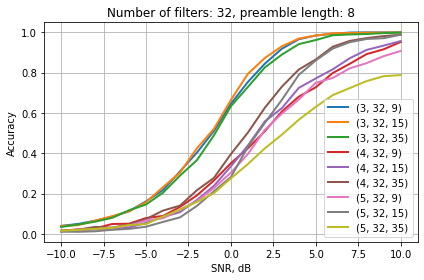

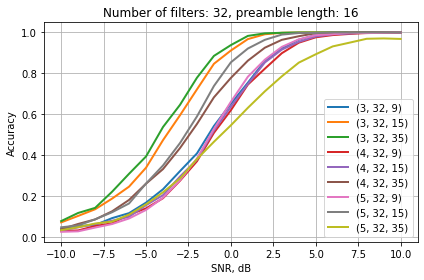

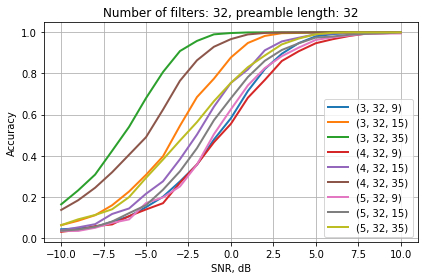

In [37]:
filter_widths = [9, 15, 35]
filters = [32]
cfo=None
legend = [(num_layers, num_filters, filter_width) for num_layers in layers
          for filter_width in filter_widths
          for num_filters in filters]


for length in preamble_lengths:
    plt.figure()
    for num_layers in layers:
        for filter_width in filter_widths:
            for num_filters in filters:
                ders = np.mean([result['ders'] for result in torch.load(f'results/ders_vs_snr_{length}_{num_layers}_{filter_width}_{num_filters}_{cfo}.pt')],axis=0)
                plt.plot(snr_range, 1-ders, linewidth=2)
#     plt.plot(snr_range, 1-torch.load(f'baselines/length_{length}_cfo_10000.0.pt')['ders'], '--k')
    # plt.plot(snr_range, 1-baselines[length], 'k--')
    plt.legend(legend, loc='lower right')
    plt.grid()
    plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
    plt.title(f'Number of filters: {num_filters}, preamble length: {length}')
    plt.tight_layout()
    # plt.savefig(f'figures/arcv_search_ders_{num_filters}_filters_{length}_width.png', dpi=300, bbox_inches='tight')

## View as dataframe
Will use pandas to export dataframe to .tex for appendix

In [45]:
# little helper to find best performers
def find_best_worst(results):
    best_acc = 0
    worst_acc = 100
    for idx, result in enumerate(results):
        mean_acc = np.mean(1-np.array(result['ders']))
        if mean_acc < worst_acc:
            worst_acc = mean_acc
            worst_idx = idx
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_idx = idx
    return best_idx, worst_idx

In [46]:
layers = [3,4,5]
filter_widths = [3,9,15,35]
filters = [16, 32]
preamble_lengths = [8, 16, 32]

table = np.zeros([len(preamble_lengths)*len(layers)*len(filters)*len(filter_widths), 8])
i = 0
for length in preamble_lengths:
    print('---')
    for num_layers in layers:
        for num_filters in filters:
            for filter_width in filter_widths:
                results = torch.load(f'results/ders_vs_snr_{length}_{num_layers}_{filter_width}_{num_filters}_{cfo}.pt')
                mean_acc = np.mean([1-result['ders'] for result in results])
                best_acc = np.mean(1-results[find_best_worst(results)[0]]['ders'])
                
                models = torch.load(f'models/{length}_preamble_{num_layers}_layers_{num_filters}_width_{filter_width}_filters.pt')
                best_loss = np.min(np.mean([model['losses'] for model in models], axis=0))
                best_val_loss = np.min(np.mean([model['val_losses'] for model in models], axis=0))
                
                table[i] = np.array([length, num_layers, num_filters, filter_width, best_loss, round(mean_acc,3), round(best_acc,3), best_val_loss])
                i+=1
                print(f'{length}, {num_layers}, {num_filters}, {filter_width}, {round(mean_acc,3)}, {round(best_acc,3)}, {best_loss:.2e}, {best_val_loss:.2e}')

---
8, 3, 16, 3, 0.235, 0.289, 3.48e-03, 3.61e-03
8, 3, 16, 9, 0.557, 0.566, 3.64e-04, 5.19e-04
8, 3, 16, 15, 0.54, 0.575, 9.05e-04, 1.08e-03
8, 3, 16, 35, 0.545, 0.553, 1.08e-04, 6.53e-04
8, 3, 32, 3, 0.277, 0.281, 2.73e-03, 2.94e-03
8, 3, 32, 9, 0.574, 0.58, 1.75e-04, 3.66e-04
8, 3, 32, 15, 0.58, 0.586, 1.05e-04, 4.03e-04
8, 3, 32, 35, 0.561, 0.575, 8.90e-05, 6.24e-04
8, 4, 16, 3, 0.154, 0.174, 1.58e-03, 1.98e-03
8, 4, 16, 9, 0.471, 0.538, 8.66e-05, 2.26e-04
8, 4, 16, 15, 0.429, 0.499, 4.69e-04, 5.91e-04
8, 4, 16, 35, 0.471, 0.553, 8.29e-05, 4.13e-04
8, 4, 32, 3, 0.1, 0.117, 1.03e-03, 1.89e-03
8, 4, 32, 9, 0.411, 0.562, 2.35e-05, 1.21e-04
8, 4, 32, 15, 0.415, 0.531, 7.00e-06, 1.65e-04
8, 4, 32, 35, 0.464, 0.551, 2.87e-04, 6.94e-04
8, 5, 16, 3, 0.163, 0.187, 1.27e-03, 1.75e-03
8, 5, 16, 9, 0.388, 0.484, 1.82e-05, 7.79e-05
8, 5, 16, 15, 0.397, 0.481, 1.37e-05, 1.09e-04
8, 5, 16, 35, 0.422, 0.518, 9.92e-04, 1.21e-03
8, 5, 32, 3, 0.113, 0.138, 5.72e-04, 1.42e-03
8, 5, 32, 9, 0.393, 0.517

In [47]:
import pandas as pd

test_frame = pd.DataFrame(data=table[:,:7], 
                          columns=['preamble', 'num layers', 'num filters', 'filter width', 
                                   'best loss', 'mean acc', 'best acc', ])

In [48]:
test_frame.head()

,preamble,num layers,num filters,filter width,best loss,mean acc,best acc
0,8.0,3.0,16.0,3.0,0.003477,0.235,0.289
1,8.0,3.0,16.0,9.0,0.000364,0.557,0.566
2,8.0,3.0,16.0,15.0,0.000905,0.540,0.575
3,8.0,3.0,16.0,35.0,0.000108,0.545,0.553
4,8.0,3.0,32.0,3.0,0.002734,0.277,0.281


Formatting not very nice, convert displays to ints to make more readble after export

In [49]:
test_frame['best loss'] = test_frame['best loss'].map('{:,.1e}'.format)
test_frame['preamble'] = test_frame['preamble'].astype(int)
test_frame['num layers'] = test_frame['num layers'].astype(int)
test_frame['num filters'] = test_frame['num filters'].astype(int)
test_frame['filter width'] = test_frame['filter width'].astype(int)

test_frame.head()

,preamble,num layers,num filters,filter width,best loss,mean acc,best acc
0,8,3,16,3,3.5e-03,0.235,0.289
1,8,3,16,9,3.6e-04,0.557,0.566
2,8,3,16,15,9.1e-04,0.540,0.575
3,8,3,16,35,1.1e-04,0.545,0.553
4,8,3,32,3,2.7e-03,0.277,0.281


In [50]:
#save as .tex
with open('arch_sweep_table.tex', 'w') as f:
    f.write(test_frame.to_latex(index=False))

## Narrower exploration

Need to explore:
* Bias on/off
* Activation functions
* Conv1D vs Conv2D

Define a new class that will allow us to loop through activation functions.

In [74]:
class preamble_detector(nn.Module):
    def __init__(self, num_layers=3, num_filters=32, width=35, activation='ReLU', bias=True):
        super(preamble_detector, self).__init__()
        
        pad = int((width-1)/2)
        
        if activation=='ReLU':
            act = torch.nn.ReLU
        elif activation=='Sigmoid':
            act = torch.nn.Sigmoid
        elif activation=='Tanh':
            act = torch.nn.Tanh
        else:
            raise('Choose ReLU, Sigmoid or Tanh')
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad), bias=bias))
        self.conv.add_module(f"relu0", act())
        
        for i in range(num_layers-2):
            self.conv.add_module(f"conv{i+1}", nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad), bias=bias))
            self.conv.add_module(f"relu{i+1}", act())
        
        self.conv.add_module(f"conv_last", nn.Conv2d(num_filters, 1, 1, 1, bias=bias))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [75]:
preamble_lengths = [8, 16, 32]
activations = ['ReLU', 'Sigmoid', 'Tanh']
lr = 0.001
num_epochs = 100
num_models = 5

In [64]:
for length in preamble_lengths:
    print(f'-----{length}-----')
    for activation in activations:
        dataset = torch.load(f'data/fcn_data_{length}_preamble_1024_examples.pt')
        # dataset = torch.load('data/fcn_data_8192.pt')

        train_data = dataset['train_data']
        labels = dataset['labels']
        val_data = dataset['val_data']
        val_labels = dataset['val_labels']

        batch_size = 32

        train_dataset = torch.utils.data.TensorDataset(train_data, labels)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        models = []
        print(f'Evaling activation -- {activation}')
        for i in range(num_models):
            print(f'Model {i}...')
            torch.manual_seed(i)
            detector = preamble_detector(3, 32, 35, activation=activation)
            detector.cuda()

            optimizer = optim.Adam(detector.parameters(), lr=lr)

            loss_fn = nn.MSELoss()

            detector, losses, val_losses, accs, val_accs = train_model(detector, optimizer, loss_fn, train_loader, val_loader, num_epochs=num_epochs)

            model_config = {"weights": detector.state_dict(),
                            "losses": losses,
                            "val_losses": val_losses,
                            "accs": accs,
                            "val_accs": val_accs,
                            "num_epochs": num_epochs,
                            "lr": lr}

            models.append(model_config)
        torch.save(models, f'models/arcv_search_activations_{length}_preamble_{activation}.pt')

-----8-----
Evaling activation -- ReLU
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling activation -- Sigmoid
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling activation -- Tanh
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
-----16-----
Evaling activation -- ReLU
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling activation -- Sigmoid
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling activation -- Tanh
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
-----32-----
Evaling activation -- ReLU
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling activation -- Sigmoid
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling activation -- Tanh
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...


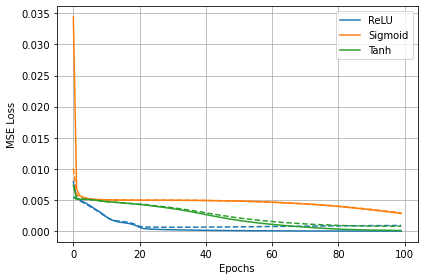

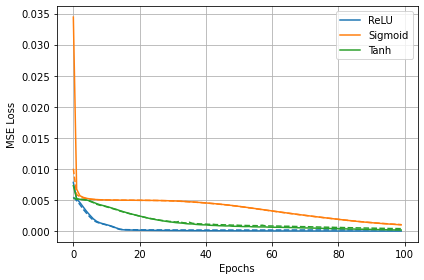

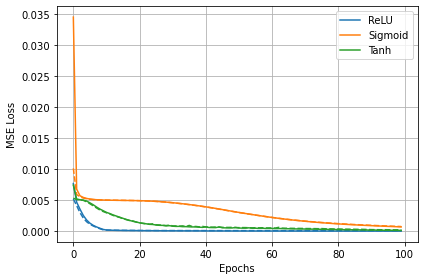

In [66]:
# fig, ax = plt.subplots(3,2, figsize=[14,12])
for j, length in enumerate(preamble_lengths):
    plt.figure()
    for i, activation in enumerate(activations):
        models = torch.load(f'models/arcv_search_activations_{length}_preamble_{activation}.pt')
        plt.plot(np.mean([model['losses'] for model in models],axis=0),f'C{i}')
        plt.plot(np.mean([model['val_losses'] for model in models],axis=0), f'--C{i}')
        # plt.plot(np.mean([model['accs'] for model in models],axis=0),f'C{i}')
        # plt.plot(np.mean([model['val_accs'] for model in models],axis=0), f'--C{i}')
    
    custom_lines = [Line2D([0], [0], color='C0'),
                    Line2D([0], [0], color='C1'),
                    Line2D([0], [0], color='C2'),
                    Line2D([0], [0], color='k', linestyle='--')]
    plt.legend(custom_lines, activations)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.tight_layout()

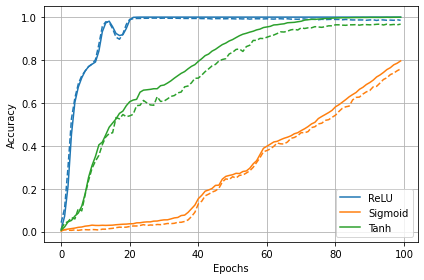

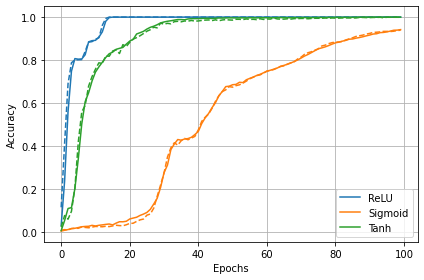

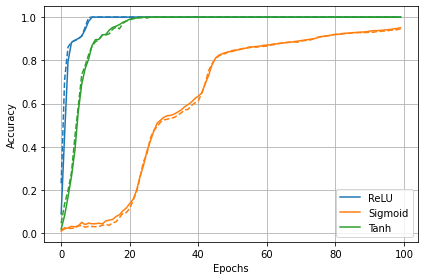

In [67]:
# fig, ax = plt.subplots(3,2, figsize=[14,12])
for j, length in enumerate(preamble_lengths):
    plt.figure()
    for i, activation in enumerate(activations):
        models = torch.load(f'models/arcv_search_activations_{length}_preamble_{activation}.pt')
        plt.plot(np.mean([model['accs'] for model in models],axis=0),f'C{i}')
        plt.plot(np.mean([model['val_accs'] for model in models],axis=0), f'--C{i}')
    
    custom_lines = [Line2D([0], [0], color='C0'),
                    Line2D([0], [0], color='C1'),
                    Line2D([0], [0], color='C2'),
                    Line2D([0], [0], color='k', linestyle='--')]
    plt.legend(custom_lines, activations)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.tight_layout()

## Bias or no bias

In [76]:
preamble_lengths = [8, 16, 32]
biases = [True, False]
lr = 0.001
num_epochs = 50
num_models = 5

In [77]:
for length in preamble_lengths:
    print(f'-----{length}-----')
    for bias in biases:
        dataset = torch.load(f'data/fcn_data_{length}_preamble_1024_examples.pt')
        # dataset = torch.load('data/fcn_data_8192.pt')

        train_data = dataset['train_data']
        labels = dataset['labels']
        val_data = dataset['val_data']
        val_labels = dataset['val_labels']

        batch_size = 32

        train_dataset = torch.utils.data.TensorDataset(train_data, labels)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        models = []
        print(f'Evaling bias -- {bias}')
        for i in range(num_models):
            print(f'Model {i}...')
            torch.manual_seed(i)
            detector = preamble_detector(3, 32, 35, activation='ReLU', bias=bias)
            detector.cuda()

            loss_fn = nn.MSELoss()

            optimizer = optim.Adam(detector.parameters(), lr=lr)

            detector, losses, val_losses, accs, val_accs = train_model(detector, optimizer, loss_fn, train_loader, val_loader, num_epochs=num_epochs)

            model_config = {"weights": detector.state_dict(),
                            "losses": losses,
                            "val_losses": val_losses,
                            "accs": accs,
                            "val_accs": val_accs,
                            "num_epochs": num_epochs,
                            "lr": lr}

            models.append(model_config)
        torch.save(models, f'models/arcv_search_bias_{length}_preamble_{bias}.pt')

-----8-----
Evaling bias -- True
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling bias -- False
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
-----16-----
Evaling bias -- True
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling bias -- False
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
-----32-----
Evaling bias -- True
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling bias -- False
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...


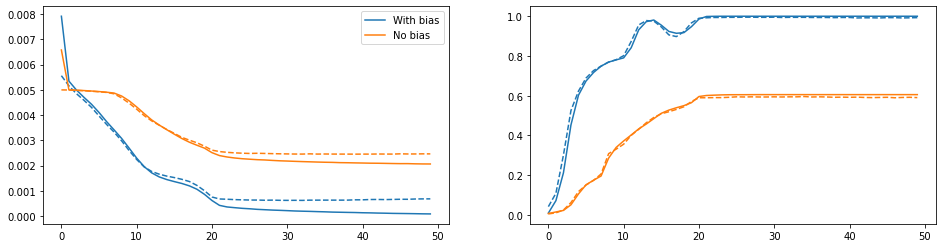

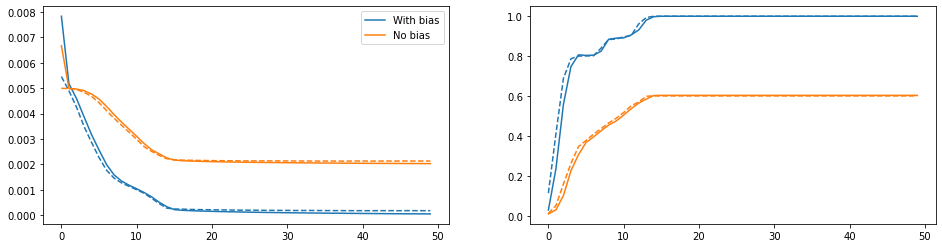

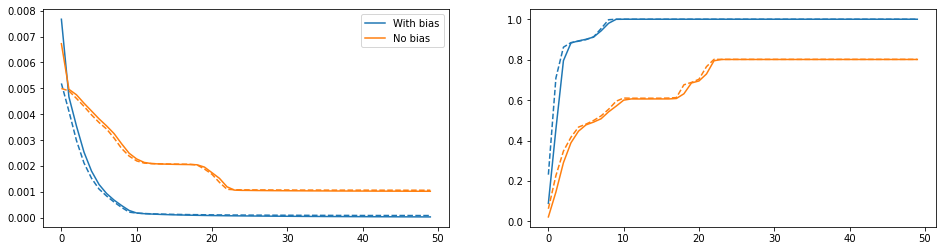

In [78]:
for length in preamble_lengths:
    fig, ax = plt.subplots(1,2, figsize=[16,4])
    for i, bias in enumerate(biases):
        models = torch.load(f'models/arcv_search_bias_{length}_preamble_{bias}.pt')
        
        mean_losses = np.mean([model['losses'] for model in models],axis=0)
        mean_val_losses = np.mean([model['val_losses'] for model in models],axis=0)
        ax[0].plot(mean_losses, f'C{i}')
        ax[0].plot(mean_val_losses, f'--C{i}')
        
        mean_accs = np.mean([model['accs'] for model in models],axis=0)
        mean_val_accs = np.mean([model['val_accs'] for model in models],axis=0)
        ax[1].plot(mean_accs, f'C{i}')
        ax[1].plot(mean_val_accs, f'--C{i}')
    
    custom_lines = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='k', linestyle='--')]
    ax[0].legend(custom_lines, ['With bias', 'No bias'])

## Bias only in the first layer

Another special new class, just to include bias in the first layer

In [79]:
class preamble_detector(nn.Module):
    def __init__(self, num_layers=3, num_filters=32, width=35, activation='ReLU', bias=True):
        super(preamble_detector, self).__init__()
        
        pad = int((width-1)/2)
        
        if activation=='ReLU':
            act = torch.nn.ReLU
        elif activation=='Sigmoid':
            act = torch.nn.Sigmoid
        elif activation=='Tanh':
            act = torch.nn.Tanh
        else:
            raise('Choose ReLU, Sigmoid or Tanh')
        
        self.conv = torch.nn.Sequential()
        
        self.conv.add_module("conv0", torch.nn.Conv2d(1, num_filters, (2,width), 1, padding=(0,pad), bias=bias))
        self.conv.add_module(f"relu0", act())
        
        for i in range(num_layers-2):
            self.conv.add_module(f"conv{i+1}", nn.Conv2d(num_filters, num_filters, (1,width), 1, padding=(0,pad)))
            self.conv.add_module(f"relu{i+1}", act())
        
        self.conv.add_module(f"conv_last", nn.Conv2d(num_filters, 1, 1, 1))

    def forward(self, x):

        # Do all convolutions
        x = self.conv(x)
        
        # Output only 1 dimension
        x = x.squeeze()

        return x

In [80]:
for length in preamble_lengths:
    print(f'-----{length}-----')
    for bias in biases:
        dataset = torch.load(f'data/fcn_data_{length}_preamble_1024_examples.pt')
        # dataset = torch.load('data/fcn_data_8192.pt')

        train_data = dataset['train_data']
        labels = dataset['labels']
        val_data = dataset['val_data']
        val_labels = dataset['val_labels']

        batch_size = 32

        train_dataset = torch.utils.data.TensorDataset(train_data, labels)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        models = []
        print(f'Evaling bias -- {bias}')
        for i in range(num_models):
            print(f'Model {i}...')
            torch.manual_seed(i)
            detector = preamble_detector(3, 32, 35, activation='ReLU', bias=bias)
            detector.cuda()

            loss_fn = nn.MSELoss()

            optimizer = optim.Adam(detector.parameters(), lr=lr)

            detector, losses, val_losses, accs, val_accs = train_model(detector, optimizer, loss_fn, train_loader, val_loader, num_epochs=num_epochs)

            model_config = {"weights": detector.state_dict(),
                            "losses": losses,
                            "val_losses": val_losses,
                            "accs": accs,
                            "val_accs": val_accs,
                            "num_epochs": num_epochs,
                            "lr": lr}

            models.append(model_config)
        torch.save(models, f'models/arcv_search_bias_layer1_{length}_preamble_{bias}.pt')

-----8-----
Evaling bias -- True
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling bias -- False
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
-----16-----
Evaling bias -- True
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling bias -- False
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
-----32-----
Evaling bias -- True
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...
Evaling bias -- False
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...


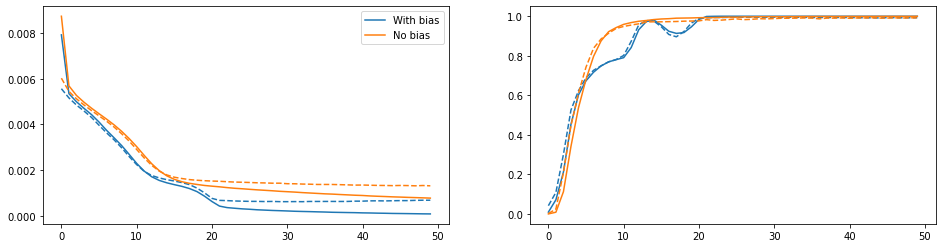

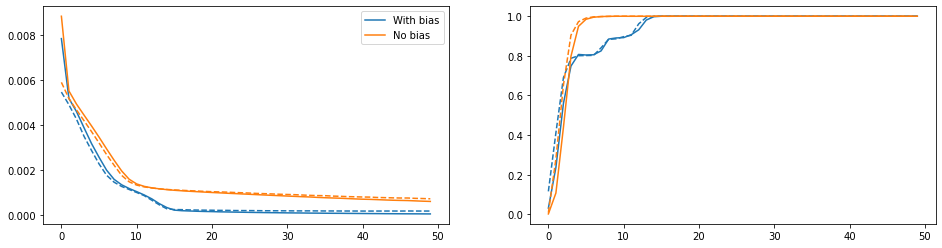

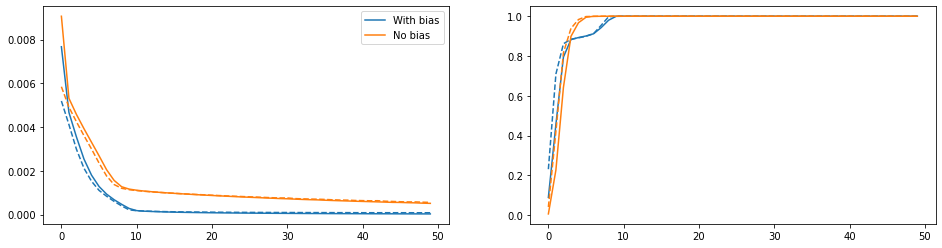

In [81]:
for length in preamble_lengths:
    fig, ax = plt.subplots(1,2, figsize=[16,4])
    for i, bias in enumerate(biases):
        models = torch.load(f'models/arcv_search_bias_layer1_{length}_preamble_{bias}.pt')
        
        mean_losses = np.mean([model['losses'] for model in models],axis=0)
        mean_val_losses = np.mean([model['val_losses'] for model in models],axis=0)
        ax[0].plot(mean_losses, f'C{i}')
        ax[0].plot(mean_val_losses, f'--C{i}')
        
        mean_accs = np.mean([model['accs'] for model in models],axis=0)
        mean_val_accs = np.mean([model['val_accs'] for model in models],axis=0)
        ax[1].plot(mean_accs, f'C{i}')
        ax[1].plot(mean_val_accs, f'--C{i}')
    
    custom_lines = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='k', linestyle='--')]
    ax[0].legend(custom_lines, ['With bias', 'No bias'])

## Save figs

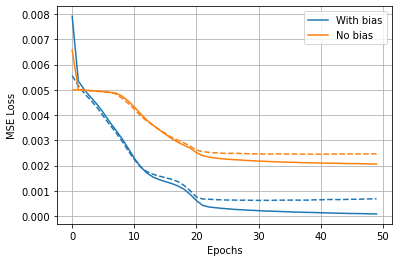

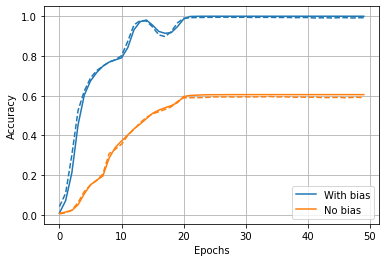

In [107]:
plt.figure()
for i, bias in enumerate(biases):
    
    models = torch.load(f'models/arcv_search_bias_8_preamble_{bias}.pt')
    
    mean_losses = np.mean([model['losses'] for model in models],axis=0)
    mean_val_losses = np.mean([model['val_losses'] for model in models],axis=0)
    plt.plot(mean_losses, f'C{i}')
    plt.plot(mean_val_losses, f'--C{i}')

custom_lines = [Line2D([0], [0], color='C0'),
            Line2D([0], [0], color='C1'),
            Line2D([0], [0], color='k', linestyle='--')]
plt.legend(custom_lines, ['With bias', 'No bias'])
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.grid()
plt.savefig(f'figures/fcn_bias_all_layers_losses.png', dpi=300, bbox_inches='tight')

plt.figure()
for i, bias in enumerate(biases):
    
    models = torch.load(f'models/arcv_search_bias_8_preamble_{bias}.pt')
    
    accs = np.mean([model['accs'] for model in models],axis=0)
    val_accs = np.mean([model['val_accs'] for model in models],axis=0)
    plt.plot(accs, f'C{i}')
    plt.plot(val_accs, f'--C{i}')

custom_lines = [Line2D([0], [0], color='C0'),
            Line2D([0], [0], color='C1'),
            Line2D([0], [0], color='k', linestyle='--')]
plt.legend(custom_lines, ['With bias', 'No bias'])
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.grid()
# plt.savefig(f'figures/fcn_bias_all_layers_accs.png', dpi=300, bbox_inches='tight')

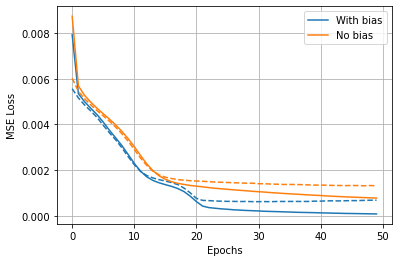

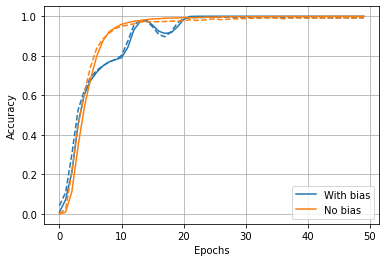

In [108]:
plt.figure()
for i, bias in enumerate(biases):
    
    models = torch.load(f'models/arcv_search_bias_layer1_8_preamble_{bias}.pt')
    
    mean_losses = np.mean([model['losses'] for model in models],axis=0)
    mean_val_losses = np.mean([model['val_losses'] for model in models],axis=0)
    plt.plot(mean_losses, f'C{i}')
    plt.plot(mean_val_losses, f'--C{i}')

custom_lines = [Line2D([0], [0], color='C0'),
            Line2D([0], [0], color='C1'),
            Line2D([0], [0], color='k', linestyle='--')]
plt.legend(custom_lines, ['With bias', 'No bias'])
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.grid()
plt.savefig(f'figures/fcn_bias_first_layer_losses.png', dpi=300, bbox_inches='tight')

plt.figure()
for i, bias in enumerate(biases):
    
    models = torch.load(f'models/arcv_search_bias_layer1_8_preamble_{bias}.pt')
    
    accs = np.mean([model['accs'] for model in models],axis=0)
    val_accs = np.mean([model['val_accs'] for model in models],axis=0)
    plt.plot(accs, f'C{i}')
    plt.plot(val_accs, f'--C{i}')

custom_lines = [Line2D([0], [0], color='C0'),
            Line2D([0], [0], color='C1'),
            Line2D([0], [0], color='k', linestyle='--')]
plt.legend(custom_lines, ['With bias', 'No bias'])
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.grid()
# plt.savefig(f'figures/fcn_bias_first_layer_accs.png', dpi=300, bbox_inches='tight')

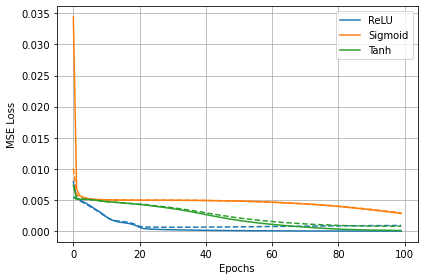

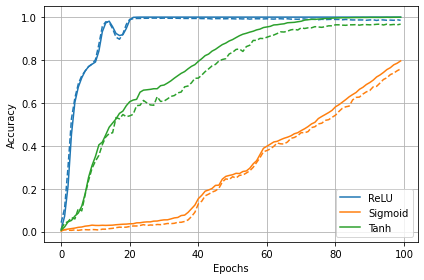

In [109]:
plt.figure()
for i, activation in enumerate(activations):
    models = torch.load(f'models/arcv_search_activations_8_preamble_{activation}.pt')
    plt.plot(np.mean([model['losses'] for model in models],axis=0),f'C{i}')
    plt.plot(np.mean([model['val_losses'] for model in models],axis=0), f'--C{i}')

custom_lines = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),
                Line2D([0], [0], color='k', linestyle='--')]
plt.legend(custom_lines, activations)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.tight_layout()
plt.savefig(f'figures/fcn_activation_functions_losses.png', dpi=300, bbox_inches='tight')

plt.figure()
for i, activation in enumerate(activations):
    models = torch.load(f'models/arcv_search_activations_8_preamble_{activation}.pt')
    plt.plot(np.mean([model['accs'] for model in models],axis=0),f'C{i}')
    plt.plot(np.mean([model['val_accs'] for model in models],axis=0), f'--C{i}')

custom_lines = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),
                Line2D([0], [0], color='k', linestyle='--')]
plt.legend(custom_lines, activations)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
# plt.savefig(f'figures/fcn_activation_functions_accs.png', dpi=300, bbox_inches='tight')